# Train Multilevel Models
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook is not necessery to deploy your model. You can use this only if you want to try to improve your best model with Multilevel Model:
* Import training and test data
* Run different models by a specific group (level) using the champion algorithm
* Compare all model performance in test dataset
* Choosing and save the best model

# 1. Parameters

In [1]:
#Name
ModelName = 'prop_apply_prospects'
#Version
ModelVersion = 'v13'
#Model ID
ModelId = ModelName+'_'+ModelVersion

#Setting the model target variable name sdf
VarTarget = 'target'

#Variable name with the groups to test different models
VarLevel = 'job_area'

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1

#Bucket already created on S3
bucket = 'data-science-lab'

#Selected Feature difined in Data_Prep
CAT = [ 'declared_seniority'
       ,'last_company_classification'
       ,'company_classification_migration'       
       ,'declared_seniority_migration'
       ,'prospect_location_state'
       ,'prospect_area_migration'
      ]
#float
NUM = [ 'prospect_smart_skills_qty'
       ,'prospect_experiences_qty'
       ,'prospect_companies_qty'
       ,'total_experience_months'
       ,'experience_duration_months_min'
       ,'experience_duration_months_clean_avg'
       ,'experience_duration_months_clean_stddev'
       ,'max_salary_offered'
       ,'last_experience_duration_months_to_avg'
       ,'prospect_linkedin_about_word_count'
       ,'last_experience_descriptions_word_count'       
       ,'import_policy_word_count'
       ,'job_technical_requirements_word_count'
       ,'job_validation_questions_word_count'
       ,'all_company_classifications_count'
      ]
selected_features = CAT + NUM

# 2. Import Libraries

In [2]:
import sys
sys.path.append('/var/lang/lib/python37.zip')
sys.path.append('/var/lang/lib/python3.7')
sys.path.append('/var/lang/lib/python3.7/lib-dynload')
sys.path.append('/var/lang/lib/python3.7/site-packages')
sys.path.remove('/opt/.sagemakerinternal/conda/lib/python3.7/site-packages')

In [3]:
import glob
import functools
import os
from time import gmtime, strftime, sleep
import datetime as dt
import pandas as pd
import numpy as np
import glob
import boto3
import awswrangler as wr
import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer
import h2o
import matplotlib.pyplot as plt
from sklearn import metrics
import shutil
import seaborn as sns

# 3. Importing Data for Modeling

In [4]:
#Create boto3 sesesion for Athena, SageMaker and S3 connection
my_boto3_session = boto3.Session(region_name='us-east-1',
    aws_access_key_id='xxxx',
    aws_secret_access_key='xxxxx',
    aws_session_token='xxxxxx')

In [5]:
query4="select * from datascience.%s" % ModelName
dataprep_df_full = wr.athena.read_sql_query(query4, database="datascience", boto3_session=my_boto3_session, s3_output='s3://query-temp-result')

In [6]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    dataprep_df = dataprep_df_full.copy()
else:
    dataprep_df = dataprep_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)
del dataprep_df_full

In [7]:
#Numeric features must be float type
for col_name in NUM:
    dataprep_df[col_name] = dataprep_df[col_name].astype(float)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    dataprep_df[col_name] = dataprep_df[col_name].astype(str)

# 4. Modeling Multilevel

## 4.2 Traning Models with H2O AutoML

## 4.2.1 Creating context and H2O

In [8]:
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = '2G')
# h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_332"; OpenJDK Runtime Environment Corretto-8.332.08.1 (build 1.8.0_332-b08); OpenJDK 64-Bit Server VM Corretto-8.332.08.1 (build 25.332-b08, mixed mode)
  Starting server from /var/lang/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp4xjl41ce
  JVM stdout: /tmp/tmp4xjl41ce/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp4xjl41ce/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/GMT
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,1 month and 6 days
H2O_cluster_name:,H2O_from_python_unknownUser_463895
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.770 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


## 4.2.2 Train the H2O Champion algorithm with new data

In [1]:
dataprep_df[[VarLevel, VarTarget]].groupby(by=VarLevel).count()

In [25]:
#Train a new model for each group of VarLevel
dict_model_list={}
dict_model_mojo_list={}

job_area_list = dataprep_df[[VarLevel]].query("job_area != 'Financeiro' & job_area != 'Missing' & job_area != 'Design'").drop_duplicates().values.tolist()

for i in job_area_list:
    vModel='h2o_champion_%s_' % i[0]
    
    dataprep_df_level = dataprep_df.query("job_area == '%s'" % i[0]).drop(columns=['job_area']).copy()
    
    #Import TRAINING base to the H20 context
    data_hdf_level = h2o.H2OFrame(dataprep_df_level.query('partition_0 == "train_data"').loc[:, (selected_features+[VarTarget])])

    # Conversion of Target variables and categorical features to factor (enum)
    #no H2O it is necessary that the categorical variables are transformed into a factor
    data_hdf_level[VarTarget] = data_hdf_level[VarTarget].asfactor()
    for col_name in CAT:
        data_hdf_level[col_name] = data_hdf_level[col_name].asfactor()
    for col_name in NUM:
        data_hdf_level[col_name] = data_hdf_level[col_name].asnumeric()

    # Partition data into 90%, 10% chunks
    # Setting a seed will guarantee reproducibility
    train_hdf_level, valid_hdf_level = data_hdf_level.split_frame(ratios=[0.90], destination_frames=['train_hdf_level', 'valid_hdf_level'], seed=1)

    #Execution time of the model
    start = dt.datetime.now()

    from h2o.estimators.gbm import H2OGradientBoostingEstimator
    dict_model_list[i[0]] = H2OGradientBoostingEstimator(model_id='%s%s%s' % (vModel, ModelId, str(dt.datetime.now())[:19].replace('-',"").replace(':',"").replace(' ',"_")),
                                        nfolds= 5,
                                        keep_cross_validation_models= False,
                                        keep_cross_validation_predictions= True,
                                        keep_cross_validation_fold_assignment= False,
                                        score_each_iteration= False,
                                        score_tree_interval= 5,
                                        fold_assignment='Modulo',
                                        fold_column= None,
                                        ignore_const_cols= True,
                                        offset_column= None,
                                        weights_column= None,
                                        balance_classes= False,
                                        class_sampling_factors= None,
                                        max_after_balance_size= 5.0,
                                        max_confusion_matrix_size= 20,
                                        ntrees= 120,
                                        max_depth= 4,
                                        min_rows= 100.0,
                                        nbins= 20,
                                        nbins_top_level= 1024,
                                        nbins_cats= 1024,
                                        r2_stopping= 1.7976931348623157e+308,
                                        stopping_rounds= 2,
                                        stopping_metric='AUCPR',
                                        stopping_tolerance= 0.002303474948339114,
                                        max_runtime_secs= 31688.0,
                                        seed= 101,
                                        build_tree_one_node= False,
                                        learn_rate= 0.1,
                                        learn_rate_annealing= 1.0,
                                        distribution='bernoulli',
                                        quantile_alpha= 0.5,
                                        tweedie_power= 1.5,
                                        huber_alpha= 0.9,
                                        checkpoint= None,
                                        sample_rate= 0.9,
                                        sample_rate_per_class= None,
                                        col_sample_rate= 0.4,
                                        col_sample_rate_change_per_level= 1.0,
                                        col_sample_rate_per_tree= 0.7,
                                        min_split_improvement= 1e-05,
                                        histogram_type='UniformAdaptive',
                                        max_abs_leafnode_pred= 1.7976931348623157e+308,
                                        pred_noise_bandwidth= 0.0,
                                        categorical_encoding='Enum',
                                        calibrate_model= False,
                                        calibration_frame= None,
                                        custom_metric_func= None,
                                        custom_distribution_func= None,
                                        export_checkpoints_dir= None,
                                        monotone_constraints= None,
                                        check_constant_response= True,
                                        gainslift_bins= -1,
                                        auc_type='AUTO',
                                        interaction_constraints= None)

    # The use of a validation_frame is recommended with using early stopping
    dict_model_list[i[0]].train(x=selected_features, y=VarTarget, training_frame=train_hdf_level, validation_frame=valid_hdf_level)
    
    h2o.save_model(model=dict_model_list[i[0]], path='%s/models/candidates/' % OutputPath, force=True)
    path_model_mojo = dict_model_list[i[0]].download_mojo('%s/models/candidates/' % OutputPath, get_genmodel_jar=True)
    dict_model_mojo_list[i[0]] = path_model_mojo
    
    del dataprep_df_level
    del data_hdf_level
    del train_hdf_level
    del valid_hdf_level

    #Execution time of the model
    stop = dt.datetime.now()
    execution_time = stop-start
    print(str(i[0]) + " Execution time: " + str(execution_time) + "\n")
#     print(dict_model_list[i[0]])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Engineering Execution time: 0:00:38.890381

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Data Execution time: 0:00:10.836413

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Arquitetura Execution time: 0:00:04.191844

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Infra Execution time: 0:00:09.838586

Parse progress: |████████████████████████████████████████████████████████████

/var/lang/lib/python3.7/site-packages/h2o/estimators/estimator_base.py:208: RuntimeWarning: Dropping bad and constant columns: [import_policy_word_count]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Salesforce Execution time: 0:00:01.296552

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Instrutor Execution time: 0:00:00.875446

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Customer Execution time: 0:00:01.539525

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
People Execution time: 0:00:01.091045



## 4.3 Compare performance on the TEST dataset for all trained models

In [32]:
#Consider all models in the history ./models/candidates/performance_*.csv. To disregard any old version, set erase_modelos = "S":
apagar_modelos = 'N'
if apagar_modelos == 'S':
    os.system('rm %s/models/candidates/performance_*.csv' % OutputPath)

In [27]:
# def predict_multilevel_model_p1(record, VarLevel, model_list):
#     return h2o.mojo_predict_pandas(record.to_frame().T.drop(columns=[VarLevel]).set_index('declared_seniority', inplace=False), mojo_zip_path=model_list[record[VarLevel]], verbose=False).loc[:,('p1')].values

# def predict_multilevel_model_predict(record, VarLevel, model_list):
#     return h2o.mojo_predict_pandas(record.to_frame().T.drop(columns=[VarLevel,]).set_index('declared_seniority', inplace=False), mojo_zip_path=model_list[record[VarLevel]], verbose=False).loc[:,('predict')].values

# datatest_df =  dataprep_df.query('partition_0 == "test_data"').drop(columns=['partition_0'])

# #Compare performance on the TEST dataset for all trained models
# plt.rcParams.update({'font.size': 12})
# fig = plt.figure(figsize=(10, 10))

# datatest_df['p1'] = datatest_df.loc[:, (selected_features+[VarLevel])].apply(lambda x: predict_multilevel_model_p1(x, VarLevel, dict_model_mojo_list), axis=1).astype(float)
# datatest_df['predict'] = datatest_df.loc[:, (selected_features+[VarLevel])].apply(lambda x: predict_multilevel_model_predict(x, VarLevel, dict_model_mojo_list), axis=1).astype(int)

In [33]:
#Create Test Dataset for calculated de performance using all the models for each specific group
datatest_df =  dataprep_df.query('partition_0 == "test_data"').drop(columns=['partition_0'])

for i in dict_model_mojo_list:
    print(i)
    
    dataprep_df_tmp = datatest_df.query('%s == "%s"' % (VarLevel, i))
    
    if i in ('Infra', 'Engineering', 'Business', 'Salesforce'):
        if i not in ('Financeiro', 'Missing', 'Design'):
            dataprep_df_tmp = dataprep_df_tmp.drop(columns=[VarLevel])

        if i in ('Salesforce', 'Instrutor'):
            dataprep_df_tmp = dataprep_df_tmp.drop(columns=['import_policy_word_count'])

        df_predict_tmp = h2o.mojo_predict_pandas(dataprep_df_tmp.set_index('declared_seniority', inplace=False), mojo_zip_path=dict_model_mojo_list[i], verbose=False)

        df_predict_tmp['model'] = dict_model_mojo_list[i]
        df_predict_tmp['group'] = i

        df_predict_tmp2 = pd.concat([df_predict_tmp.reset_index(drop=True), datatest_df.query('job_area == "%s"' % i).reset_index(drop=True)], axis=1)

        if i == 'Engineering':
            df_predict = df_predict_tmp2
        else:
            df_predict = df_predict.append(df_predict_tmp2)
    else:        
        df_predict_tmp = h2o.mojo_predict_pandas(dataprep_df_tmp.set_index('declared_seniority', inplace=False), mojo_zip_path='/home/sagemaker-user/data-science-lab/tamplates/output_model/models/best/GBM_grid_1_AutoML_1_20220628_13109_model_7.zip', verbose=False)

        df_predict_tmp['model'] = dict_model_mojo_list[i]
        df_predict_tmp['group'] = i

        df_predict_tmp2 = pd.concat([df_predict_tmp.reset_index(drop=True), datatest_df.query('job_area == "%s"' % i).reset_index(drop=True)], axis=1)

        if i == 'Engineering':
            df_predict = df_predict_tmp2
        else:
            df_predict = df_predict.append(df_predict_tmp2)            
# df_predict

Engineering
Data
Arquitetura
Infra
Marketing
Mobile
Business
Agile
Product
Segurança
Sales
Salesforce
Instrutor
Customer
People


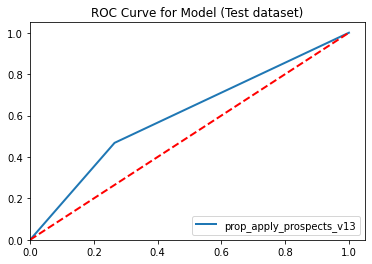

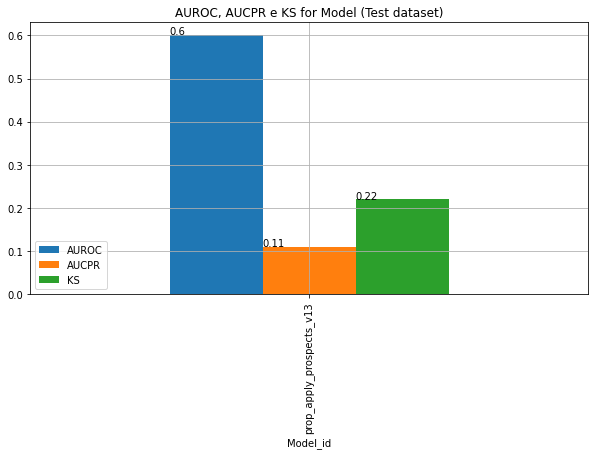

In [34]:
data = df_predict.copy()
data['target0'] = 1 - data[VarTarget]
data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
grouped = data.groupby('bucket', as_index=False)
kstable = pd.DataFrame()
kstable['min_prob'] = grouped.min()['p1']
kstable['max_prob'] = grouped.max()['p1']
kstable['events'] = grouped.sum()[VarTarget]
kstable['nonevents'] = grouped.sum()['target0']
kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
kstable['cum_eventrate'] = kstable['cum_eventrate'].astype(float)
kstable['cum_noneventrate'] = kstable['cum_noneventrate'].astype(float)
kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
ks = kstable['KS'].max()

accuracy = metrics.accuracy_score(df_predict[VarTarget].astype(str), df_predict['predict'].astype(str))
fpr, tpr, thresholds = metrics.roc_curve(df_predict[VarTarget].astype(int), df_predict['predict'].astype(int), pos_label=1)
auc = metrics.auc(fpr, tpr)
aucpr = metrics.average_precision_score(df_predict[VarTarget].astype(int), df_predict['predict'].astype(int), pos_label=1)
f1 = metrics.f1_score(df_predict[VarTarget].astype(str), df_predict['predict'].astype(str), pos_label='1')
log_loss = metrics.log_loss(df_predict[VarTarget].astype(str), df_predict['predict'].astype(str))

#Salve metrics
f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, ModelId), 'w')
f.write(
    str(ModelId) + ";"
    + str(accuracy) + ";"
    + str(auc) + ';'
    + str(aucpr) + ';'
    + str(log_loss) + ';'
    + str(ks) + ';'
    + str(f1))
f.write('\n')
f.close()

plt.plot(fpr, tpr, lw=2, label=ModelId)
plt.title("ROC Curve for Model (Test dataset)")

df_plot = pd.DataFrame({'Model_id': ModelId,
                            'AUROC': int(auc*100)/100,
                            'AUCPR': int(aucpr*100)/100,
                            'KS': int(ks*100)/100
                            }, index=[0])
        
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()
plt.close()
ax = df_plot.plot(kind='bar', x="Model_id", title="AUROC, AUCPR e KS for Model (Test dataset)", grid=True, figsize=(10,5), legend=1)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.legend(loc=3, prop={'size': 10})

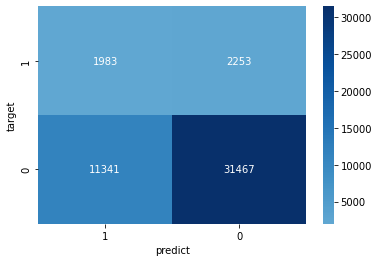

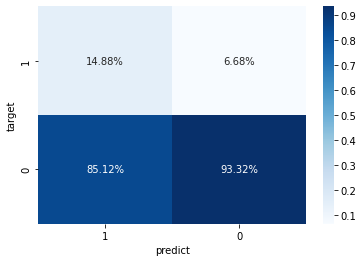

In [35]:
df_matrix = df_predict.reset_index().groupby([VarTarget, 'predict']).count()[['index']].reset_index().pivot(index=VarTarget, columns='predict', values='index').sort_values(by=[VarTarget], ascending=False).loc[:,(1,0)]

sns.heatmap(df_matrix, annot=True, center=True,cmap='Blues', fmt='g')
plt.show()
sns.heatmap(df_matrix/np.sum(df_matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

## 6.4 Choose the best model among all tested

In [36]:
sort_metric_best_model='AUCPR'
#import all tested models and print the 10 bests sorted by AUC on the screen
modelos_testados = pd.concat(map(functools.partial(pd.read_csv, sep=';', header=None), glob.glob('%s/models/candidates/performance_*.csv' % OutputPath)))
modelos_testados.columns = ('model_id', 'accuracy', 'AUC', 'AUCPR', 'logloss', 'KS', 'F1')
modelos_testados = modelos_testados.sort_values(by=sort_metric_best_model, ascending=False)
modelos_testados = modelos_testados.drop_duplicates(subset=["model_id"])
print('MBest Models. Sorted by : ' + str(sort_metric_best_model))
modelos_testados.reset_index(0).head(100)

MBest Models. Sorted by : AUCPR


,index,model_id,accuracy,AUC,AUCPR,logloss,KS,F1
0,0,GBM_grid_1_AutoML_1_20220628_13109_model_7,0.492766,0.657022,0.169787,0.289870,0.225,0.127367
1,0,h2o_champion_prop_apply_prospects_v1220220628_...,0.518036,0.660925,0.166613,0.289825,0.229,0.114218
2,0,autopilot-prop-apply-28-01-28-w1-015-63aeaca12...,0.671351,0.610519,0.119256,11.351372,0.228,0.227481
3,0,prop_apply_prospects_v13,0.711036,0.601602,0.117563,9.980639,0.224,0.225854
4,0,prop_apply_prospects_v12,0.726436,0.578369,0.110285,9.448724,0.218,0.207819
